In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


In [10]:
##### Design a query to retrieve the last 12 months of precipitation data and plot the results
# Find last date of the db
last_date = session.query(Measurement.date)[-1]
#type(last_date)
#Convert date from string to date
last_date_dt = dt.datetime.strptime(last_date.date, '%Y-%m-%d')

In [11]:
# Calculate the date 1 year ago from the last data point in the database
last_date_year = last_date_dt - dt.timedelta(days=365)
print(last_date_year)

2016-08-23 00:00:00


In [12]:
# Perform a query to retrieve the data and precipitation scores
precipitation_values = []
date_values = []
prcps = session.query(Measurement).filter(Measurement.date> last_date_year)
for result in prcps: 
    prcp = result.prcp
    precipitation_values.append(prcp)
    date = result.date
    date_values.append(date)
    
#precipitation_values
#date_values

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_data = {'Date': date_values, 'Precipitation': precipitation_values}
precipitation_df = pd.DataFrame(precipitation_data)
precipitation_df.head()

,Date,Precipitation
0,2016-08-24,0.08
1,2016-08-25,0.08
2,2016-08-26,0.00
3,2016-08-27,0.00
4,2016-08-28,0.01


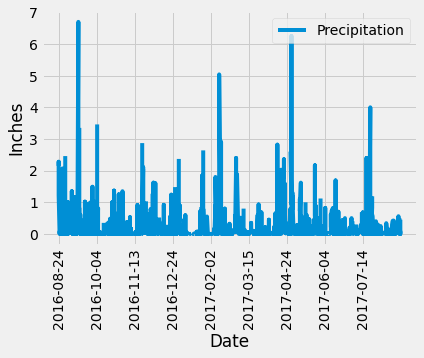

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
#Pull x and y data
precipitation_df=precipitation_df.sort_values(by=['Date'])
x_axis = precipitation_df['Date']
y_axis = precipitation_df['Precipitation']

#Plot graph
fig, ax = plt.subplots()
plt.plot(x_axis, y_axis, label = "Precipitation")
plt.ylabel ("Inches")
#plt.ylim(0,8)
plt.xlabel("Date")
plt.xticks(np.arange(0, 365, 365/9), rotation = '90')
plt.legend(loc='upper right')
  
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station).count()
print(f"There are {station_count} stations included in this data set.")

There are 9 stations included in this data set.


# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

In [20]:
#Collect station information
station=[]
count=[]
activity = session.query(Measurement).group_by(Measurement.station)
for x in activity: 
    station.append(x.station)
#Group by station
total = session.query(func.count(Measurement.id)).group_by(Measurement.station)
for x in total: 
    count.append(x)
combined = []
for i in range(len(count)):
    combined.append((count[i][0], station[i]))
    
# Switch column order and print out activity by station in descending order.
combined.sort(reverse=True)
combined_col_switch = []
for i in range(len(combined)):
    combined_col_switch.append((combined[i][1], combined[i][0]))

station_activity_df = pd.DataFrame(combined_col_switch) 
station_activity_df.rename(columns={0: "Station", 1: "Count"})
station_activity_df

,0,1
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [21]:
#Determine the most active station
most_active_station = combined_col_switch[0][0]
active_count = combined_col_switch[0][1]
print(f"Station {most_active_station} is the most active and has the most rows (a total of {active_count} rows).")

Station USC00519281 is the most active and has the most rows (a total of 2772 rows).


In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

#Make the query for the most active station temp data
tobs = session.query(Measurement.tobs).filter(Measurement.station == most_active_station)
#lowest temperature
tobs_low = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active_station)
for i in tobs_low: 
    print(f"The lowest temperature on record for the most active station: {i[0]} F.")
#highest temperature
tobs_high = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active_station)
for i in tobs_high: 
    print(f"The highest temperature on record for the most active station: {i[0]} F.")
#average temperature
tobs_avg = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station)
for i in tobs_avg: 
    print(f"The average temperature on record for the most active station: {round(i[0],1)} F.")


The lowest temperature on record for the most active station: 54.0 F.
The highest temperature on record for the most active station: 85.0 F.
The average temperature on record for the most active station: 71.7 F.


# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


In [23]:
# Choose the station with the highest number of temperature observations.
# Make list of stations
station_list = []
stations = session.query(Measurement).group_by(Measurement.station)
for i in stations: 
    if i.station not in station_list: 
        station_list.append(i.station)
#make temp observations query
tobs_query = session.query(Measurement.tobs)
#loop through the stations and find the amount of tobs data per station
tobs_data = []
for a in station_list: 
    count_check=0
    station=a
    station_filter = tobs_query.filter(Measurement.station == station)
    for i in station_filter:
        if i.tobs != np.isnan(i.tobs): 
            count_check+=1
    tobs_data.append((count_check, a))
#once all data is stored, sort list and pull out the station with the most data
sorted_list = sorted(tobs_data, reverse=True)
most_tobs = sorted_list[0][1]
print(f"The station with the most temperature observations is {most_tobs}.")

The station with the most temperature observations is USC00519281.


In [24]:
#  Query the last 12 months of temperature observation data for this station
tobs_12months = session.query(Measurement).filter(Measurement.station == most_tobs).filter(Measurement.date> last_date_year)
date= []
tobs = []
for i in tobs_12months:
    date.append(i.date)
    tobs.append(i.tobs)


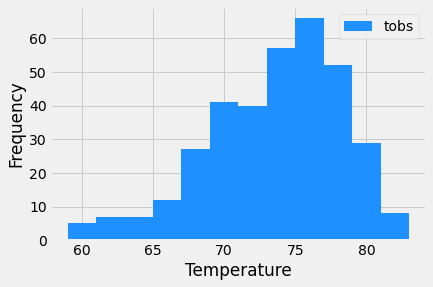

In [25]:
# Plot the results as a histogram

plt.hist(x=tobs, bins=12, color='dodgerblue', label="tobs")
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.show()

## Bonus Challenge Assignment

#### Temperature Analysis I

##### Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the 
##### temperature in, for example, June and December?

##### You may either use SQLAlchemy or pandas's read_csv() to perform this portion.

##### Identify the average temperature in June at all stations across all available years in the dataset. 
##### Do the same for December temperature.

##### Use the t-test to determine whether the difference in the means, if any, is statistically significant. 
##### Will you use a paired t-test, or an unpaired t-test? Why?

In [26]:
import os
import csv


csv_path = os.path.join("Resources", "hawaii_measurements.csv")

measurement_df = pd.read_csv(csv_path, encoding="utf-8")
measurement_df.head()

,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65
1,USC00519397,2010-01-02,0.00,63
2,USC00519397,2010-01-03,0.00,74
3,USC00519397,2010-01-04,0.00,76
4,USC00519397,2010-01-06,NaN,73


In [27]:
import datetime

#Get Temp data into dataframe and group by month
measurement_df['month'] = pd.DatetimeIndex(measurement_df['date']).month
temp_df = measurement_df.groupby(['month']).mean()
temp_df1 = measurement_df.groupby(['month'])

#Pull June and Dec average temp data
june_temp_avg = round(temp_df.iloc[5,1],2)
dec_temp_avg = round(temp_df.iloc[11,1],2)

print(f"The average temperature in June for all stations is {june_temp_avg} F.")
print(f"The average temperature in December for all stations is {dec_temp_avg} F.")


The average temperature in June for all stations is 74.94 F.
The average temperature in December for all stations is 71.04 F.


In [28]:
#Perform paired T test
# Paired test was chosen because the two temp datasets are from the same locations with date as the only variable
import scipy
from scipy import stats

scipy.stats.ttest_rel(june_temp_avg,dec_temp_avg)
#No significant difference as determined by the t Test

C:\Users\corey\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\corey\Anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\corey\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\corey\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\corey\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Ttest_relResult(statistic=nan, pvalue=nan)

##### Temperature Analysis II

In [29]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [30]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_calc = calc_temps('2017-08-01', '2017-08-15')
trip_calc = [trip_calc[0][0], trip_calc[0][1], trip_calc[0][2]]

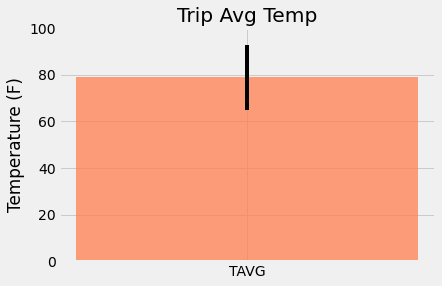

In [31]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
labels = ['TMIN', 'TAVG', 'TMAX']
plt.bar(labels[1], trip_calc[1], yerr = (trip_calc[2]-trip_calc[0]), color = 'coral', alpha = .75)
plt.title ('Trip Avg Temp')
plt.ylabel('Temperature (F)')
plt.ylim(0, 100)
plt.show()


#### Daily Rainfall Average


##### Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
###### Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [184]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
